In [1]:
import os
os.chdir(os.path.dirname(os.path.abspath('..')))

device_ids = [2]

# CUDA
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, device_ids))

In [22]:
import torchvision
import torch
from torch import Tensor
from torch import nn
from typing import Type, List, Union, Callable, Optional, Any
import types
from torchvision.models.resnet import BasicBlock, Bottleneck, conv1x1, conv3x3

In [23]:
in_t = torch.tensor([[[0]*45]*16]*1, dtype=torch.float32).unsqueeze(0)

In [31]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        in_channels: int = 3,
        layer_channels: Optional[List[int]] = None,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        if layer_channels is None:
            layer_channels = [64, 128, 256, 512]
        self.layer_channels = layer_channels
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(in_channels, self.inplanes, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(block, self.layer_channels[0], layers[0])
        self.layer2 = self._make_layer(block, self.layer_channels[1], layers[1], stride=1, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, self.layer_channels[2], layers[2], stride=1, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, self.layer_channels[3], layers[3], stride=1, dilate=replace_stride_with_dilation[2])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[Any],
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model

In [32]:
model = _resnet(BasicBlock, [2, 2, 2, 2], None, False, in_channels=1, layer_channels=[64, 64, 64, 128])

In [33]:
model(in_t).shape

torch.Size([1, 128, 16, 45])

In [6]:
import logging
import sys
from pathlib import Path
from datetime import date, datetime, timedelta
from typing import Tuple, List
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython import display

from AltimeterAutoencoder.src import _types
from AltimeterAutoencoder.src.regressor import fit_regressor, MetaRegression
from Models.AttentionConvLSTM import SaveLoadModels
from Models.AttentionConvLSTM.training_loop import train_validation_loop
from Models.AttentionConvLSTM.Seq2SeqAttention import Seq2SeqAttention, InputModel, OutputModel
from Models.Shared import Loss, DatasetParameters
from Models.Shared.Dataloader import SLADataset
from Models.AttentionConvLSTM import Attention, Encoder, Decoder
from Models.AttentionConvLSTM.Loss import create_masked_loss_function_diff

%load_ext autoreload
%autoreload 2
%matplotlib inline

def print_to_file_on_epoch(loss: Loss, _: _types.float_like, __: _types.float_like, n_epochs: int):
    logger = logging.getLogger(__name__)
    logger.info(f"Epoch: {loss.epoch:04d}/{n_epochs} Training Loss: {loss.training_loss:.7f} Validation Loss: {loss.validation_loss:.7f}")

def setup_model(
    in_channels: int,
    encoder_in_channels: int,
    encoder_out_channels: int,
    kernel_size: Tuple[int, int],
    padding: Tuple[int, int],
    frame_size: Tuple[int, int],
    hidden_output_network_channels: List[int]
) -> Seq2SeqAttention:
    # Construct models
    input_model = InputModel(in_channels, encoder_in_channels)

    encoder = Encoder(
        in_channels = encoder_in_channels,
        out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        activation = nn.Tanh(),
        frame_size = frame_size,
    )

    attention = Attention(encoder_out_channels, encoder_out_channels)

    decoder = Decoder(
        in_channels = encoder_in_channels,
        hidden_channels = encoder_out_channels,
        out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        activation = nn.Tanh(),
        frame_size = frame_size,
        attention = attention
    )

    output_network = OutputModel(
        in_channels = decoder.resulting_channels,
        hidden_channels = hidden_output_network_channels,
        output_channels = in_channels
    )
    return Seq2SeqAttention(input_model, encoder, decoder, output_network)

def load_model(
    model_path: Path,
    device: torch.device,
    regressor_path: Path
) -> Tuple[Seq2SeqAttention, torch.optim.Optimizer, Loss, DatasetParameters, MetaRegression, int, str]:
    model, optimizer, last_loss, dataset_parameters = SaveLoadModels.load_checkpoint(
        model_path,
        Seq2SeqAttention,
        device
    )
    with open(regressor_path, 'rb') as file:
        regressor = MetaRegression.load(file)
    start_epoch = last_loss.epoch
    return model, optimizer, last_loss, dataset_parameters, regressor, start_epoch

def setup_data(
    datapath: Path,
    save_path: Path,
    dataset_parameters: DatasetParameters,
    regressor: MetaRegression | None = None
) -> Tuple[DataLoader[SLADataset], DataLoader[SLADataset]]:
    with xr.open_dataset(DATAPATH, engine="netcdf4") as file:
        file = file.sortby('time')
        sla = file['sla21'][:, :-1][:, 20:40, 185:225].data
        times: _types.time_like = file['time'].data

    # Set train, validation and test intervals
    train_start_np = np.array(dataset_parameters.train_start).astype("datetime64[ns]")
    train_end = np.array(dataset_parameters.train_end).astype("datetime64[ns]")
    validation_end = np.array(dataset_parameters.validation_end).astype("datetime64[ns]")

    # Save times
    bool_train = (times > train_start_np) & (times <= train_end)
    bool_validation = (times > train_end) & (times <= validation_end)

    if regressor is None:
        regressor = fit_regressor(times[bool_train], sla[bool_train], save_path)

    sla -= regressor.predict(times).reshape(*sla.shape)
    train_time: _types.int_like = times[bool_train].astype("datetime64[D]").astype(int)
    validation_time: _types.int_like = times[bool_validation].astype("datetime64[D]").astype(int)

    # Save sla features
    train_features = sla[bool_train]
    validation_features = sla[bool_validation]

    # Kwargs to dataloaders
    kwargs_dataloader = {
        'shuffle': False,
        'batch_size': dataset_parameters.batch_size
    }

    # Dataloders
    train_loader = DataLoader(SLADataset(train_features, train_time, dataset_parameters), **kwargs_dataloader)
    validation_loader = DataLoader(SLADataset(validation_features, validation_time, dataset_parameters), **kwargs_dataloader)
    return train_loader, validation_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
extent = [5.5, 44.5, -44.5, -25.5]
def setup_plot_on_epoch(print_to_file: bool = True, day_number: int = 29):
    losses = []
    epochs = []
    train_loss = []
    val_loss = []
    times = []
    
    fig, axs = plt.subplots(4, 2, figsize=(14, 21))
    gs_true = axs[2, 0].get_gridspec()
    gs_pred = axs[3, 0].get_gridspec()

    # remove the underlying axes
    for ax in axs[2:, :].flatten():
        ax.remove()
    ax_example_img_true = fig.add_subplot(gs_true[2, :])
    ax_example_img_pred = fig.add_subplot(gs_pred[3, :])
    ((ax_epoch, ax_epoch_all), (ax_learningrate, ax_time)) = axs[:2, :]
    
    def update_line(loss, example_img_true, example_img_pred, total_epochs):
        # try:
        if print_to_file:
            print_to_file_on_epoch(loss, example_img_true, example_img_pred, total_epochs)

        losses.append(loss)
        train_loss.append(loss.training_loss)
        val_loss.append(loss.validation_loss)
        epochs.append(loss.epoch)

        if len(losses) > 1:
            total_seconds = (loss.time - losses[-2].time).total_seconds()/60
            estimated_next_epoch = datetime.now() + timedelta(seconds=total_seconds*60)
            times.append(total_seconds)
            fig.suptitle(f"Estimated time left: {total_seconds/60 * (total_epochs - loss.epoch):.2f} h\nEstimated next epoch: {estimated_next_epoch.strftime('%H:%M:%S')}")
            ax_time.plot(epochs[1:], times, color='red')

        ax_epoch.plot(epochs, train_loss, color='red', label="Training")
        ax_epoch.plot(epochs, val_loss, color='blue', label="Validation")
        ax_epoch.set_ylim([min(train_loss[-1], val_loss[-1])*0.9, max(train_loss[-1], val_loss[-1])*1.1])

        ax_epoch_all.plot(epochs, train_loss, color='red', label="Training")
        ax_epoch_all.plot(epochs, val_loss, color='blue', label="Validation")        

        im_pred = ax_example_img_pred.imshow(example_img_pred[day_number], extent=extent, vmin=-0.7, vmax=0.7, origin='lower', cmap='jet')
        im_true = ax_example_img_true.imshow(example_img_true[day_number], extent=extent, vmin=-0.7, vmax=0.7, origin='lower', cmap='jet')


        if len(epochs) == 1:
            ax_epoch.set_title(f"Loss")
            ax_epoch.legend(loc='upper right')
            ax_epoch.set_xlabel("Epoch")
            ax_epoch.set_ylabel("Loss")
            ax_epoch.grid()

            ax_epoch_all.set_title(f"Loss")
            ax_epoch_all.legend(loc='upper right')
            ax_epoch_all.set_xlabel("Epoch")
            ax_epoch_all.set_ylabel("Loss")
            ax_epoch_all.grid()

            ax_time.set_xlabel("Epoch")
            ax_time.set_ylabel("Time [Minutes]")
            ax_time.grid()

            ax_learningrate.set_xlabel("Epoch")
            ax_learningrate.set_ylabel("Learning rate")
            ax_learningrate.grid()

            ax_example_img_true.set_title(f"True image {day_number + 1} days")
            ax_example_img_true.set_xlabel("Lon")
            ax_example_img_true.set_ylabel("Lat")

            ax_example_img_pred.set_title(f"Prediction {day_number + 1} days")
            ax_example_img_pred.set_xlabel("Lon")
            ax_example_img_pred.set_ylabel("Lat")
            plt.colorbar(im_true, ax = ax_example_img_true)
            plt.colorbar(im_pred, ax = ax_example_img_pred)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        # except:
        #     pass
    return update_line

In [4]:
DATAPATH = Path(r"Data/Grids/without_polar_v5_mss21.nc")
SAVEFOLDER = Path("SavedModels", "ConvLSTMAttentionSouthAfrica")
MODEL_NAME = "checkpoint_25.pkl"
SAVEFOLDER.mkdir(parents=True, exist_ok=True)
LOAD_MODEL = True

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

logger = logging.getLogger(__name__)
stream_handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('%(asctime)s:%(message)s')
stream_handler.setFormatter(formatter)
stream_handler.setLevel(logging.DEBUG)

file_handler = logging.FileHandler(SAVEFOLDER / 'log.log')
file_handler.setFormatter(formatter)
file_handler.setLevel(logging.DEBUG)

logger.addHandler(stream_handler)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)


# Dataset parameters
default_batch_size = 40
default_sequence_length = 30
default_sequence_steps = 1
default_prediction_steps = 1
default_n_predictions = 30

# Model parameters
kernel_size = (3, 3)
padding = ((kernel_size[0] - 1)//2, (kernel_size[1] - 1)//2)
frame_size = (20, 40)
encoder_in_channels = 32
encoder_out_channels = 32
hidden_output_network_channels = [32, 32]

# Training loop
# Start: 53 - 1e-6
# Switch: 53 - 1e-3
learning_rate = 1e-4
weight_decay = 0
epochs = 2000
save_every = 25
n_sequences = 30
scheduler = None
teacher_forcing_ratio_list: List[float] = [0]*epochs
fill_nan = 0
train_start = date(2006, 1, 1)
train_end = date(2014, 1, 1)
validation_end = date(2019, 1, 1)

In [7]:
# Loss
criterion = create_masked_loss_function_diff(nn.MSELoss)

regressor = None
if LOAD_MODEL:
    model, optimizer, last_loss, dataset_parameters, regressor, start_epoch = load_model(
        SAVEFOLDER / MODEL_NAME,
        DEVICE,
        SAVEFOLDER / "Regression.pkl"
    )

In [9]:
if not LOAD_MODEL:
    dataset_parameters = DatasetParameters(
        batch_size = default_batch_size,
        sequence_length = default_sequence_length,
        sequence_steps = default_sequence_steps,
        prediction_steps = default_prediction_steps,
        fill_nan = fill_nan,
        train_start = train_start,
        train_end = train_end,
        validation_end = validation_end,
        n_predictions = default_n_predictions,
    )
    start_epoch = 0

    model = setup_model(
        in_channels = 1,
        encoder_in_channels = encoder_in_channels,
        encoder_out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        frame_size = frame_size,
        hidden_output_network_channels = []
    ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

try:
    with open(SAVEFOLDER / "Regression.pkl", 'rb') as file:
        regressor = MetaRegression.load(file)
except:
    regressor = None
    
train_loader, validation_loader = setup_data(
    DATAPATH,
    SAVEFOLDER / "Regression.pkl",
    dataset_parameters, # type: ignore
    regressor
)

In [11]:
with torch.no_grad():
    while True:
        features, target, mask, _, result_time = next(iter(validation_loader))
        # Save time
        batch_size = result_time.size(0)
        target_times = result_time.numpy()

        if torch.any(torch.all(torch.all(mask, dim=3), dim=2)):
            continue

        # Move to device
        features = features.to(DEVICE)
        target = target.to(DEVICE)
        mask = mask.to(DEVICE)

        # Predict
        output = model(features, None, n_sequences, 0)
        target = target.squeeze(1)
        output[mask] = np.nan
        target[mask] = np.nan
        output = output.detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        break

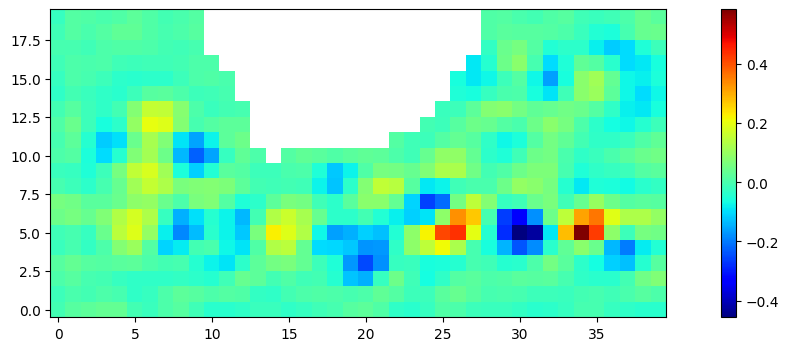

In [12]:
import cmcrameri.cm as cmc
batch_id = 0
channel_id = 0
day_id = 29
plt.figure(figsize=(14,4))
plt.imshow(output[batch_id, day_id], origin='lower', cmap='jet')
plt.colorbar()
plt.show()

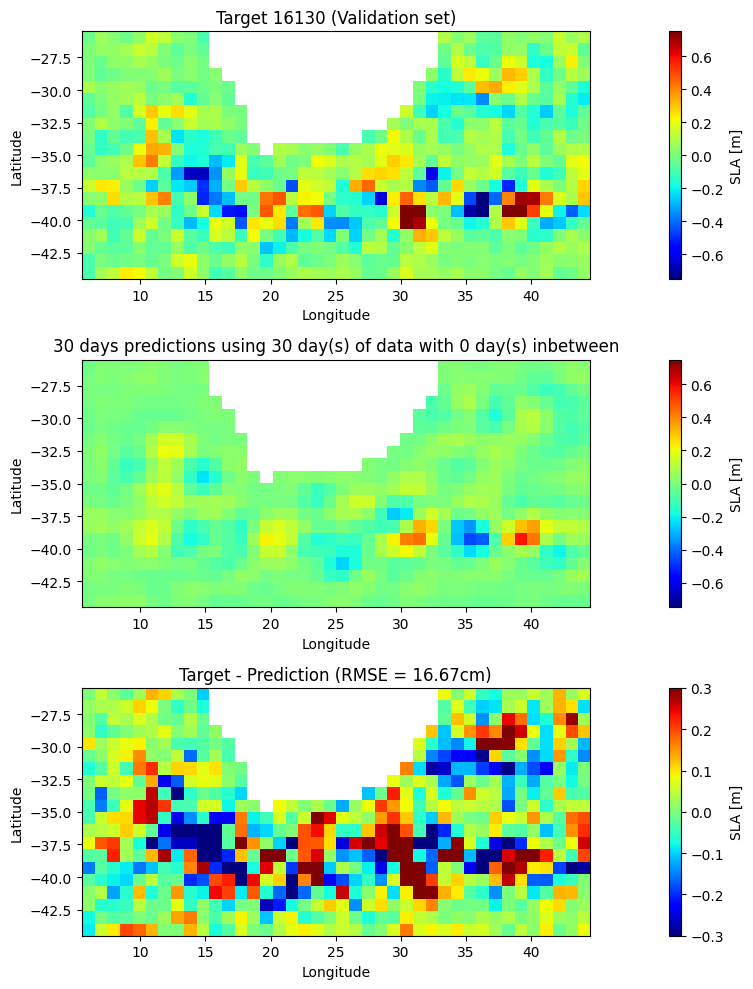

In [13]:
def get_pred_title_multi(dataset_parameters: DatasetParameters, n_predictions: int):
    return f"{n_predictions * dataset_parameters.prediction_steps} days predictions using {dataset_parameters.sequence_length} day(s) of data\nwith {dataset_parameters.sequence_steps - 1} day(s) inbetween"

def get_pred_title(dataset_parameters: DatasetParameters, n_predictions: int):
    return get_pred_title_multi(dataset_parameters, n_predictions).replace('\n', ' ')

idx = 0
day_prediction = 29

vmin = -0.75
vmax = 0.75
cmap = 'jet'

vmin_diff = -0.3
vmax_diff = 0.3

diffs = target - output
diff_data = diffs[idx, day_prediction]
diff_vector = diff_data[~np.isnan(diff_data)].flatten()
rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))

fig, axes = plt.subplots(3, 1, figsize=(16,10))
im_target = axes[0].imshow(target[idx, day_prediction], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_pred = axes[1].imshow(output[idx, day_prediction], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)

axes[0].set_title(f"Target {target_times[idx, day_prediction]} (Validation set)")
axes[1].set_title(get_pred_title(dataset_parameters, day_prediction + 1))
axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")

for ax in axes.flatten():
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")

caxs = []
caxs.append(fig.colorbar(im_target))
caxs.append(fig.colorbar(im_pred))
caxs.append(fig.colorbar(im_diff))

for cax in caxs:
    cax.ax.set_ylabel("SLA [m]")

plt.tight_layout()
plt.show()

In [14]:
import matplotlib.animation
import matplotlib

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [15]:
plt.ioff()
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
vmin = -0.75
vmax = 0.75
cmap = 'jet'#cmc.vik

idx = 0
vmin_diff = -0.3
vmax_diff = 0.3

for ax in axes.flatten():
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")

diff_data = diffs[idx, 0]
diff_vector = diff_data[~np.isnan(diff_data)].flatten()
rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))

im_target = axes[0].imshow(target[idx, 0], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_pred = axes[1].imshow(output[idx, 0], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)

axes[0].set_title(f"Target {target_times[idx, day_prediction]} (Validation set)")
axes[1].set_title(get_pred_title(dataset_parameters, 1))
axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")
caxs = []
caxs.append(fig.colorbar(im_target))
caxs.append(fig.colorbar(im_pred))
caxs.append(fig.colorbar(im_diff))

for cax in caxs:
    cax.ax.set_ylabel("SLA [m]")    

def animate(t):
    plt.cla()
    diff_data = diffs[idx, t]
    diff_vector = diff_data[~np.isnan(diff_data)].flatten()
    rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))
    
    im_target = axes[0].imshow(target[idx, t], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
    im_pred = axes[1].imshow(output[idx, t], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
    im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)
    
    axes[0].set_title(f"Target {target_times[idx, day_prediction]} (Validation set)")
    axes[1].set_title(get_pred_title(dataset_parameters, t + 1))
    axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")

anim  = matplotlib.animation.FuncAnimation(fig, animate, frames=29)



anim.save(SAVEFOLDER / f'{SAVEFOLDER.name}.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


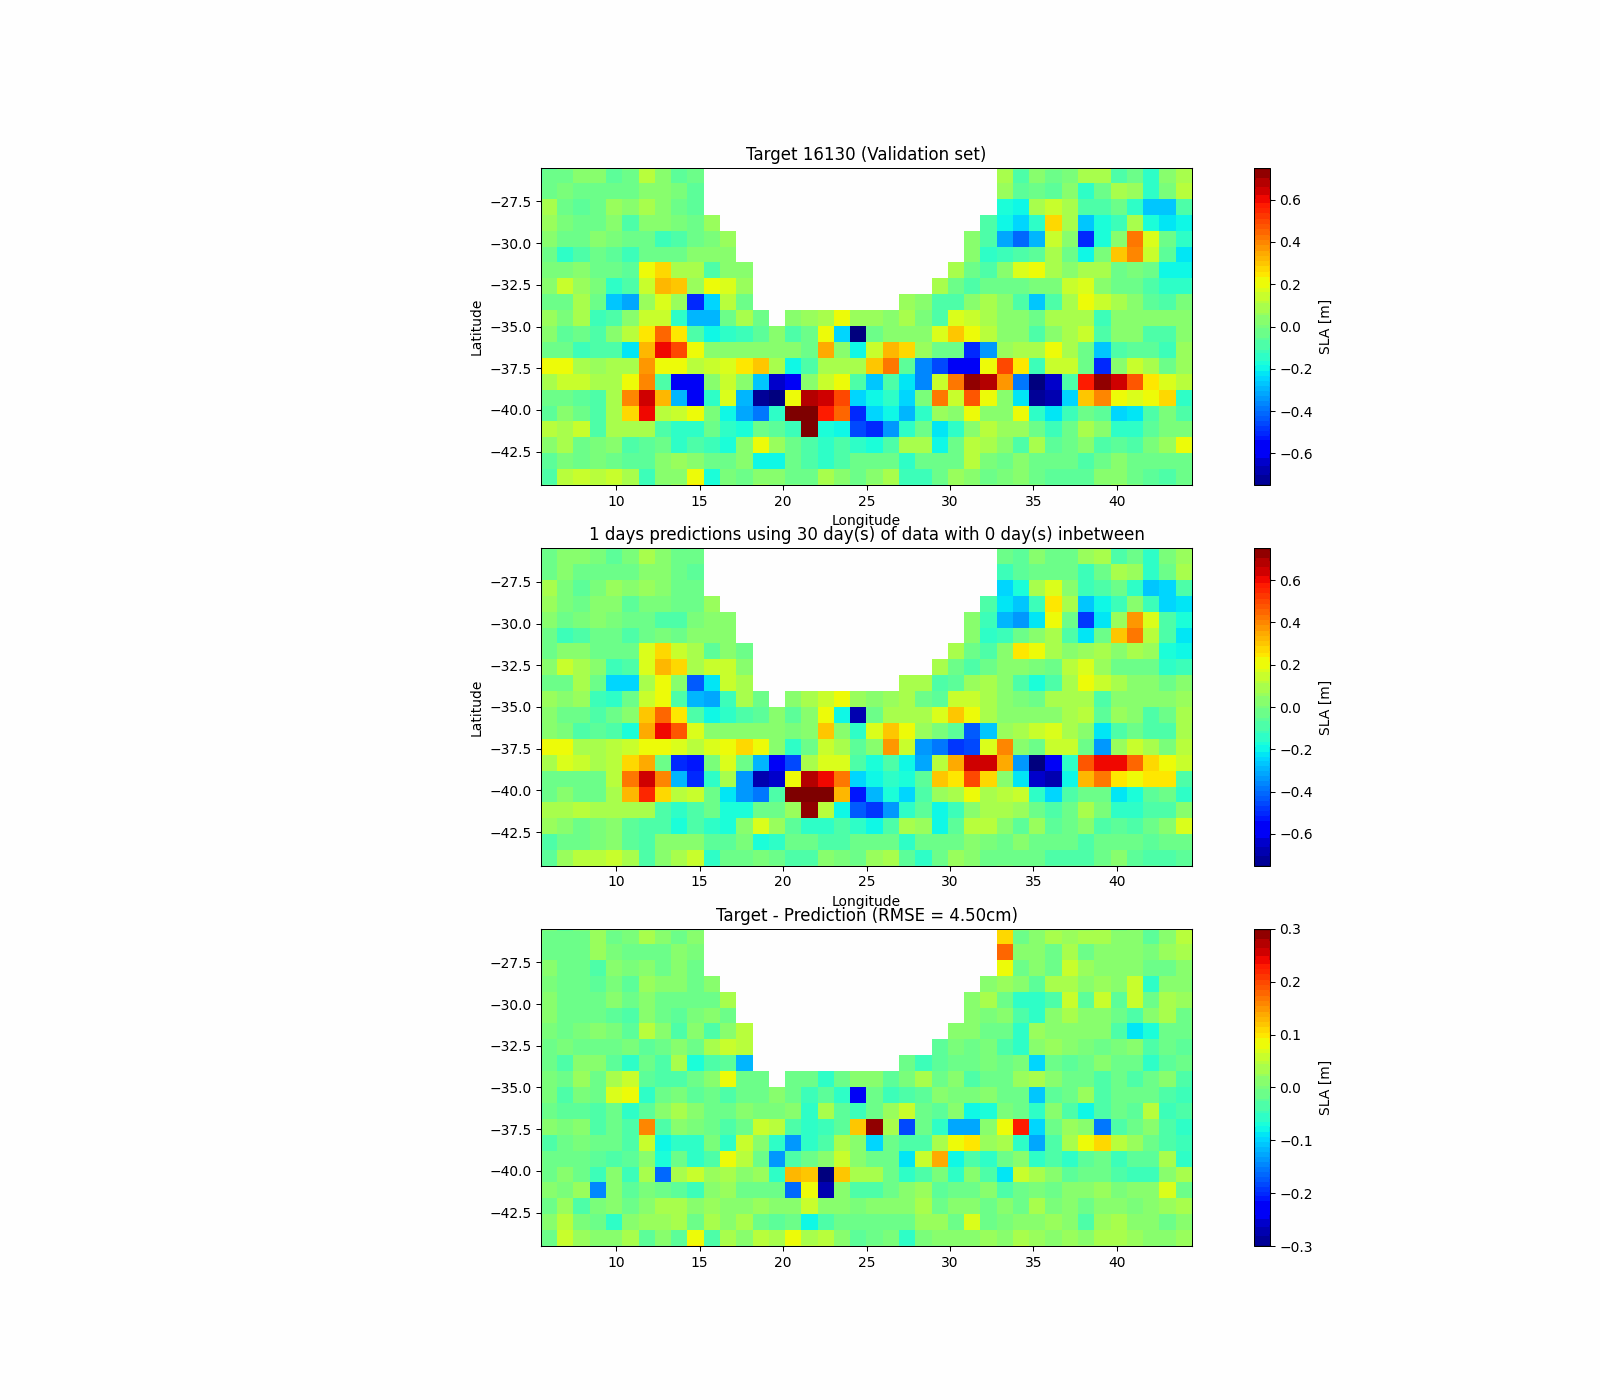

In [16]:
gif_file = (SAVEFOLDER / f'{SAVEFOLDER.name}.gif').as_posix()
display.Image(open(gif_file,'rb').read())